In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

os.makedirs("outputs", exist_ok=True)

print("Setup complete.")


Setup complete.


In [2]:
trades = pd.read_csv('/historical_data.csv', low_memory=False)
sent = pd.read_csv('/fear_greed_index.csv', low_memory=False)

print("Trades shape:", trades.shape)
print("Sentiment shape:", sent.shape)

trades.head()


Trades shape: (9322, 16)
Sentiment shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')
sent.columns = sent.columns.str.strip().str.lower().str.replace(' ', '_')

print("Trade columns:\n", trades.columns)
print("\nSentiment columns:\n", sent.columns)


Trade columns:
 Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')

Sentiment columns:
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [5]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')

trades['trade_date'] = trades['timestamp_ist'].dt.date

sent['date'] = pd.to_datetime(sent['date'], errors='coerce')
sent['sent_date'] = sent['date'].dt.date

trades[['timestamp_ist', 'trade_date']].head()


,timestamp_ist,trade_date
0,2024-02-12 22:50:00,2024-02-12
1,2024-02-12 22:50:00,2024-02-12
2,2024-02-12 22:50:00,2024-02-12
3,2024-02-12 22:50:00,2024-02-12
4,2024-02-12 22:50:00,2024-02-12


In [6]:
num_cols = ['execution_price', 'size_tokens', 'size_usd',
            'closed_pnl', 'fee', 'start_position']

for col in num_cols:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

trades[num_cols].describe()


,execution_price,size_tokens,size_usd,closed_pnl,fee,start_position
count,9322.000000,9322.000000,9.322000e+03,9321.000000,9321.000000,9321.000000
mean,49191.668048,1059.878604,2.460060e+04,102.601612,4.382276,9939.327651
std,41482.127576,12233.125457,1.073477e+05,881.750184,17.882360,72901.641524
min,0.007412,0.000010,1.000000e-01,-29370.119800,0.000000,-1000000.000000
25%,24.697250,0.024118,4.808525e+02,0.000000,0.005136,-14.326510
50%,83154.500000,0.582000,1.703585e+03,0.000000,0.193821,22.895270
75%,85038.000000,35.790000,9.999870e+03,9.073984,1.929505,248.379748
max,87385.000000,682429.000000,3.509753e+06,27223.741500,754.307241,600000.000000


In [7]:
daily = trades.groupby('trade_date').agg({
    'size_tokens': ['sum', 'mean'],
    'size_usd': ['sum', 'mean'],
    'closed_pnl': ['sum', 'mean'],
    'execution_price': 'mean',
    'account': 'nunique',
    'side': lambda x: x.value_counts().to_dict()
})

daily.columns = ['_'.join(map(str, c)) for c in daily.columns]

daily = daily.reset_index().rename(columns={'trade_date': 'date'})
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.set_index('date')

daily.head()


,size_tokens_sum,size_tokens_mean,size_usd_sum,size_usd_mean,closed_pnl_sum,closed_pnl_mean,execution_price_mean,account_nunique,side_<lambda>
date,,,,,,,,,
2024-02-12,10004.000000,227.363636,78277.30,1779.029545,0.000000,0.000000,7.825377,1,{'BUY': 44}
2024-03-12,12000.490000,82.762000,565317.04,3898.738207,20925.513222,144.313884,146.239012,1,"{'SELL': 105, 'BUY': 40}"
2024-04-12,0.008602,0.008602,0.10,0.100000,0.000000,0.000000,11.076000,1,{'SELL': 1}
2024-09-12,5663.140000,134.836667,70653.29,1682.221190,0.000000,0.000000,12.477667,1,{'BUY': 42}
2024-12-12,17478.060000,164.887358,320319.36,3021.880755,0.000000,0.000000,18.277745,2,"{'BUY': 89, 'SELL': 17}"


In [8]:
sent_daily = sent[['sent_date', 'classification']].drop_duplicates()
sent_daily = sent_daily.rename(columns={'sent_date': 'date'})
sent_daily['date'] = pd.to_datetime(sent_daily['date'])
sent_daily = sent_daily.set_index('date')

combined = daily.join(sent_daily, how='left')

combined['classification'] = combined['classification'].fillna(method='ffill')

combined.head()


/tmp/ipython-input-1192400506.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined['classification'] = combined['classification'].fillna(method='ffill')


,size_tokens_sum,size_tokens_mean,size_usd_sum,size_usd_mean,closed_pnl_sum,closed_pnl_mean,execution_price_mean,account_nunique,side_<lambda>,classification
date,,,,,,,,,,
2024-02-12,10004.000000,227.363636,78277.30,1779.029545,0.000000,0.000000,7.825377,1,{'BUY': 44},Greed
2024-03-12,12000.490000,82.762000,565317.04,3898.738207,20925.513222,144.313884,146.239012,1,"{'SELL': 105, 'BUY': 40}",Extreme Greed
2024-04-12,0.008602,0.008602,0.10,0.100000,0.000000,0.000000,11.076000,1,{'SELL': 1},Extreme Greed
2024-09-12,5663.140000,134.836667,70653.29,1682.221190,0.000000,0.000000,12.477667,1,{'BUY': 42},Fear
2024-12-12,17478.060000,164.887358,320319.36,3021.880755,0.000000,0.000000,18.277745,2,"{'BUY': 89, 'SELL': 17}",Extreme Greed


In [9]:
combined.to_csv('/content/daily_trade_sentiment.csv')

print("Saved as /content/daily_trade_sentiment.csv")


Saved as /content/daily_trade_sentiment.csv


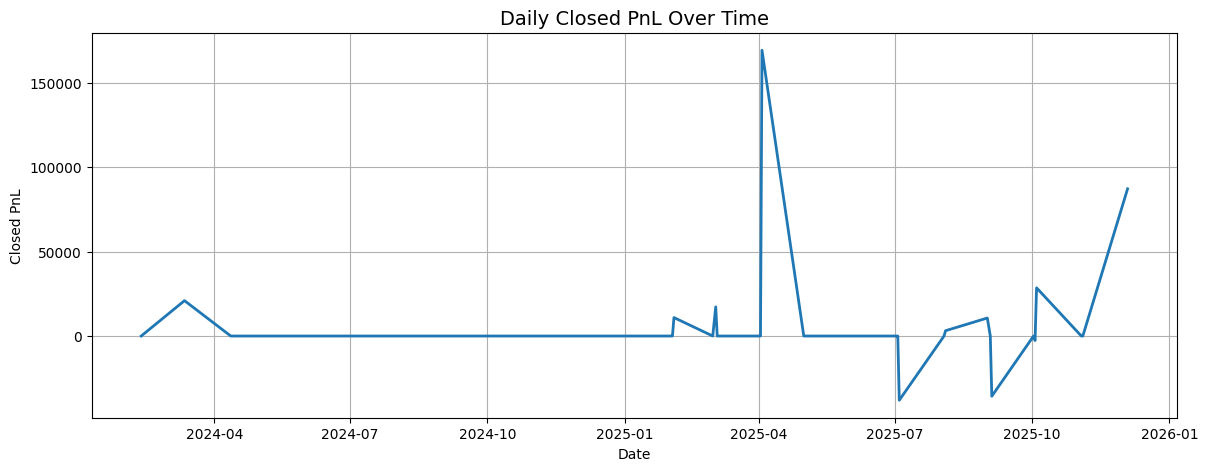

In [10]:
plt.figure(figsize=(14,5))
plt.plot(combined.index, combined['closed_pnl_sum'], linewidth=2)
plt.title("Daily Closed PnL Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Closed PnL")
plt.grid(True)
plt.savefig("outputs/daily_closedpnl.png")
plt.show()


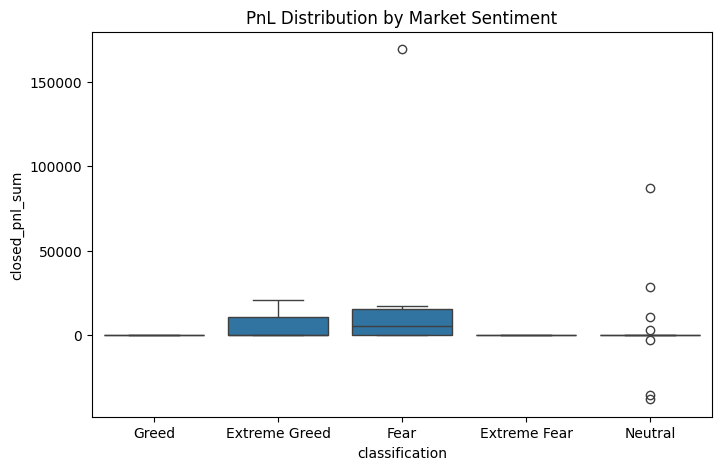

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x='classification',
    y='closed_pnl_sum',
    data=combined.reset_index()
)
plt.title("PnL Distribution by Market Sentiment")
plt.savefig("outputs/pnl_by_sentiment.png")
plt.show()


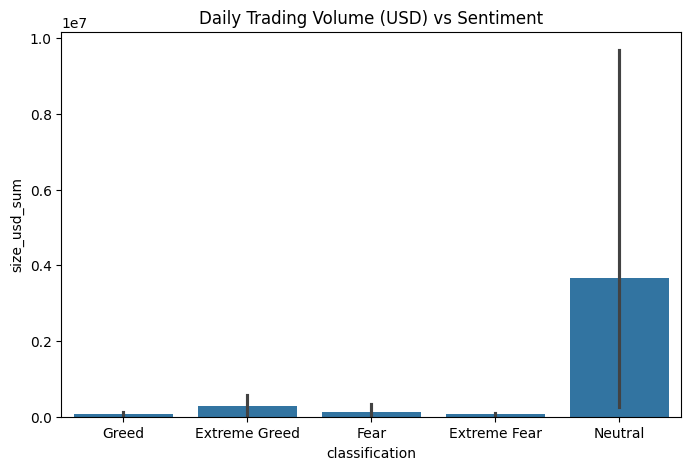

In [12]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='classification',
    y='size_usd_sum',
    data=combined.reset_index()
)
plt.title("Daily Trading Volume (USD) vs Sentiment")
plt.savefig("outputs/volume_by_sentiment.png")
plt.show()


In [13]:
from scipy import stats

fear_pnl = combined[combined['classification']=='Fear']['closed_pnl_sum'].dropna()
greed_pnl = combined[combined['classification']=='Greed']['closed_pnl_sum'].dropna()

t_stat, p_val = stats.ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("T-test between Fear and Greed PnL")
print("t-stat:", t_stat)
print("p-value:", p_val)


T-test between Fear and Greed PnL
t-stat: 1.1997712608558786
p-value: 0.2839723420573553
